In [91]:
import torch
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.cm as cm
%matplotlib inline

sys.path.append('..')
from src.embedding.gym_dataset import AbstractActionsData
from src.embedding.gym_dataset import GymData
from src.embedding.gym_dataset import load_or_generate

In [110]:
import wandb

wandb.init(project='dyne-visualise', entity='vinnibuh')

In [3]:
encoder = torch.load('../models/encoder/dmc_hopper_hop/DynE-4/encoder.pt')
data = AbstractActionsData('dmc_hopper_hop', 4, encoder)

gym_data = torch.load('../datasets/torch/dmc_hopper_hop_len4_n100000_qposFalse_qvelFalse_deltaTrue_whitenTrue_pixelsFalse.pt')
data.mean, data.std = gym_data.mean, gym_data.std

del gym_data

data.load_from_directory('../datasets/dreamer/dreamer_finetuned/episodes')

In [19]:
raw_obs, raw_action, raw_reward = data[0]
raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])

mu, logvar, _ = data.transform_episode(0)

numbers_ak = []
rewards_ak = []
embeddings_ak = []
for k in range(100):
    raw_obs, raw_action, raw_reward = data[k]
    raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])
    rewards = raw_reward[1:].reshape([250, 2]).sum(axis=1)
    for idx, vector in enumerate(raw_embeddings):
        embeddings_ak.append(vector.numpy())
        numbers_ak.append(idx)
        rewards_ak.append(rewards[idx])
    
tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='random', n_iter=3500, random_state=32, n_jobs=8)
embeddings_ak_2d = tsne_ak_2d.fit_transform(np.array(embeddings_ak))
print('done')

dyne_numbers_ak = []
dyne_emb_ak = []
for k in range(100):
    mu, logvar, _ = data.transform_episode(k)
    for idx, vector in enumerate(mu):
        dyne_emb_ak.append(vector.numpy())
        dyne_numbers_ak.append(idx)
    
tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='random', n_iter=3500, random_state=32, n_jobs=8)
embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(np.array(dyne_emb_ak))

In [80]:
def tsne_plot_2d(label, embeddings, color_style='time', words=[], rewards=[], a_points=1, a_text=0.6, size=15, 
                 log=False, ax=None, annotate=False, episodes_num=100):
    plt.figure(figsize=(16, 9))
    if color_style == 'time':
        colors = cm.coolwarm(np.linspace(0, 1, int(len(embeddings)/episodes_num)))
        colors = np.tile(colors, (episodes_num, 1))
    elif color_style == 'rewards':
        rewards = np.array(rewards)
        scaled_rewards = rewards / rewards.max()
        colors = cm.coolwarm(scaled_rewards)
    elif color_style == 'episodes':
        colors = cm.coolwarm(np.linspace(0, 1, episodes_num))
        colors = np.repeat(colors, int(len(embeddings)/episodes_num), 0)
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, s=size, c=colors, alpha=a_points, label=label)
    if annotate:
        for i, word in enumerate(words):
            plt.annotate(word, alpha=a_text, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("{}.png".format(label), format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb.log({label: wandb.Image(plt)})
    else:
        plt.show()

In [109]:
wandb.finish()

_runtime,48
_timestamp,1623249624
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [115]:
import pathlib

In [118]:
import pickle

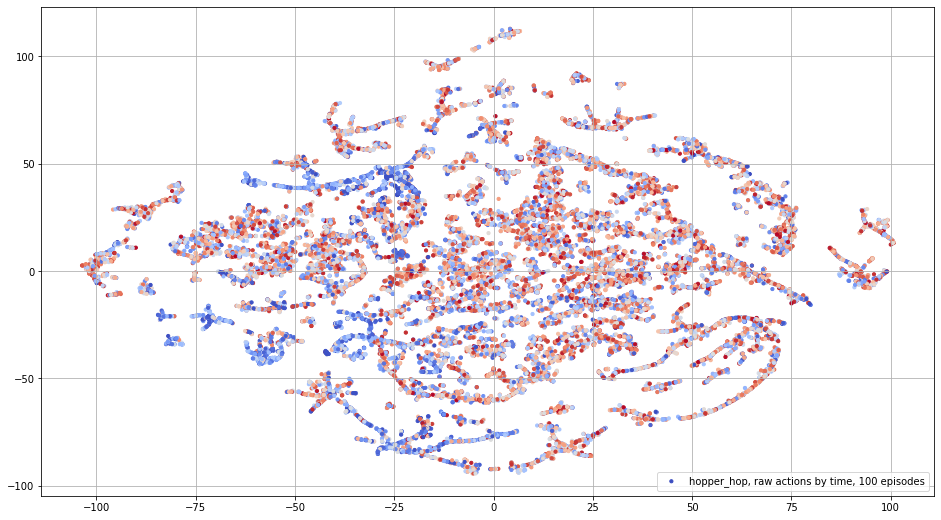

In [108]:
tsne_plot_2d('hopper_hop, raw actions by time, 100 episodes', embeddings_ak_2d, color_style='time', rewards=rewards_ak, size=10, a_text=0, log=True)

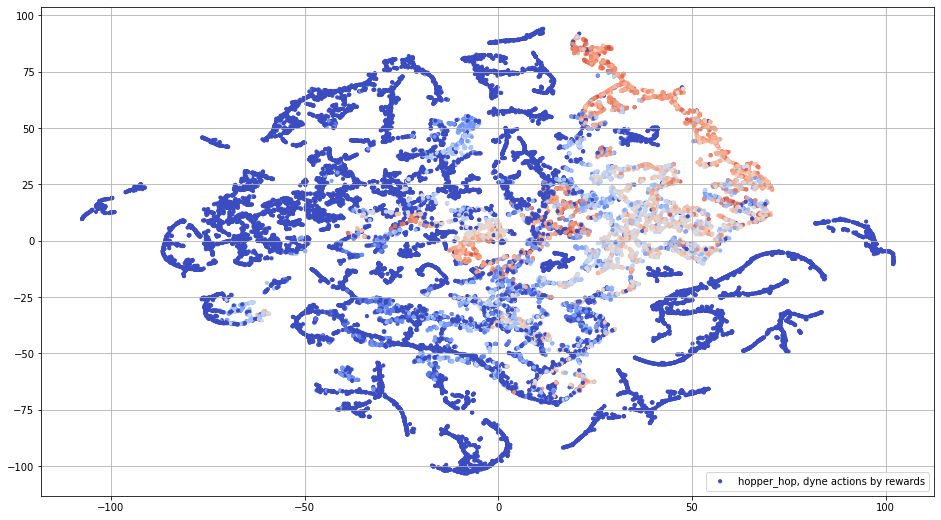

In [124]:
tsne_plot_2d('hopper_hop, dyne actions by rewards', t, color_style='rewards', rewards=rewards_ak, a_text=0, size=10, log=True)

In [114]:
wandb.log({})

In [4]:
def vis_embeddings(label, embeddings, words=[], a_points=1, a_text=0.6, ax=None):
    colors = cm.coolwarm(np.linspace(0, 1, len(embeddings)))
    x = embeddings[:,0]
    y = embeddings[:,1]
    ax.scatter(x, y, c=colors, alpha=a_points, label=label)
    for i, word in enumerate(words):
        ax.annotate(word, alpha=a_text, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    ax.legend(loc=4)
    ax.grid(True)

def compare_embeddings_vis_2d(label, data, n_samples, a_points=1, a_text=0.6, log=False):
    sample_idx = random.sample(range(len(data)), n_samples)
    fig, axes = plt.subplots(n_samples, 2, figsize=(30, 60))
    
    for idx, s in enumerate(sample_idx):
        
        raw_obs, raw_action, raw_reward = data[s]
        raw_embeddings = torch.repeat_interleave(raw_action[1:], 2, dim=0).reshape([250, 16])

        mu, logvar = data.transform_episode(s)

        numbers_ak = []
        embeddings_ak = []
        for k, vector in enumerate(raw_embeddings):
            embeddings_ak.append(vector.numpy())
            numbers_ak.append(k)
    
        tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)
        
        vis_embeddings("episode {}, raw actions".format(s), embeddings_ak_2d, 
                       numbers_ak, a_text=0, ax=axes[idx][0])

        dyne_numbers_ak = []
        dyne_emb_ak = []

        for k, vector in enumerate(mu):
            dyne_emb_ak.append(vector.numpy())
            dyne_numbers_ak.append(k)
    
        tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(dyne_emb_ak)
        
        vis_embeddings("episode {}, dyne actions".format(s), embeddings_dyne_ak_2d, 
                       dyne_numbers_ak, a_text=0, ax=axes[idx][1])
        
    fig.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb.log({label: wandb.Image(fig)})
    else:
        plt.show()

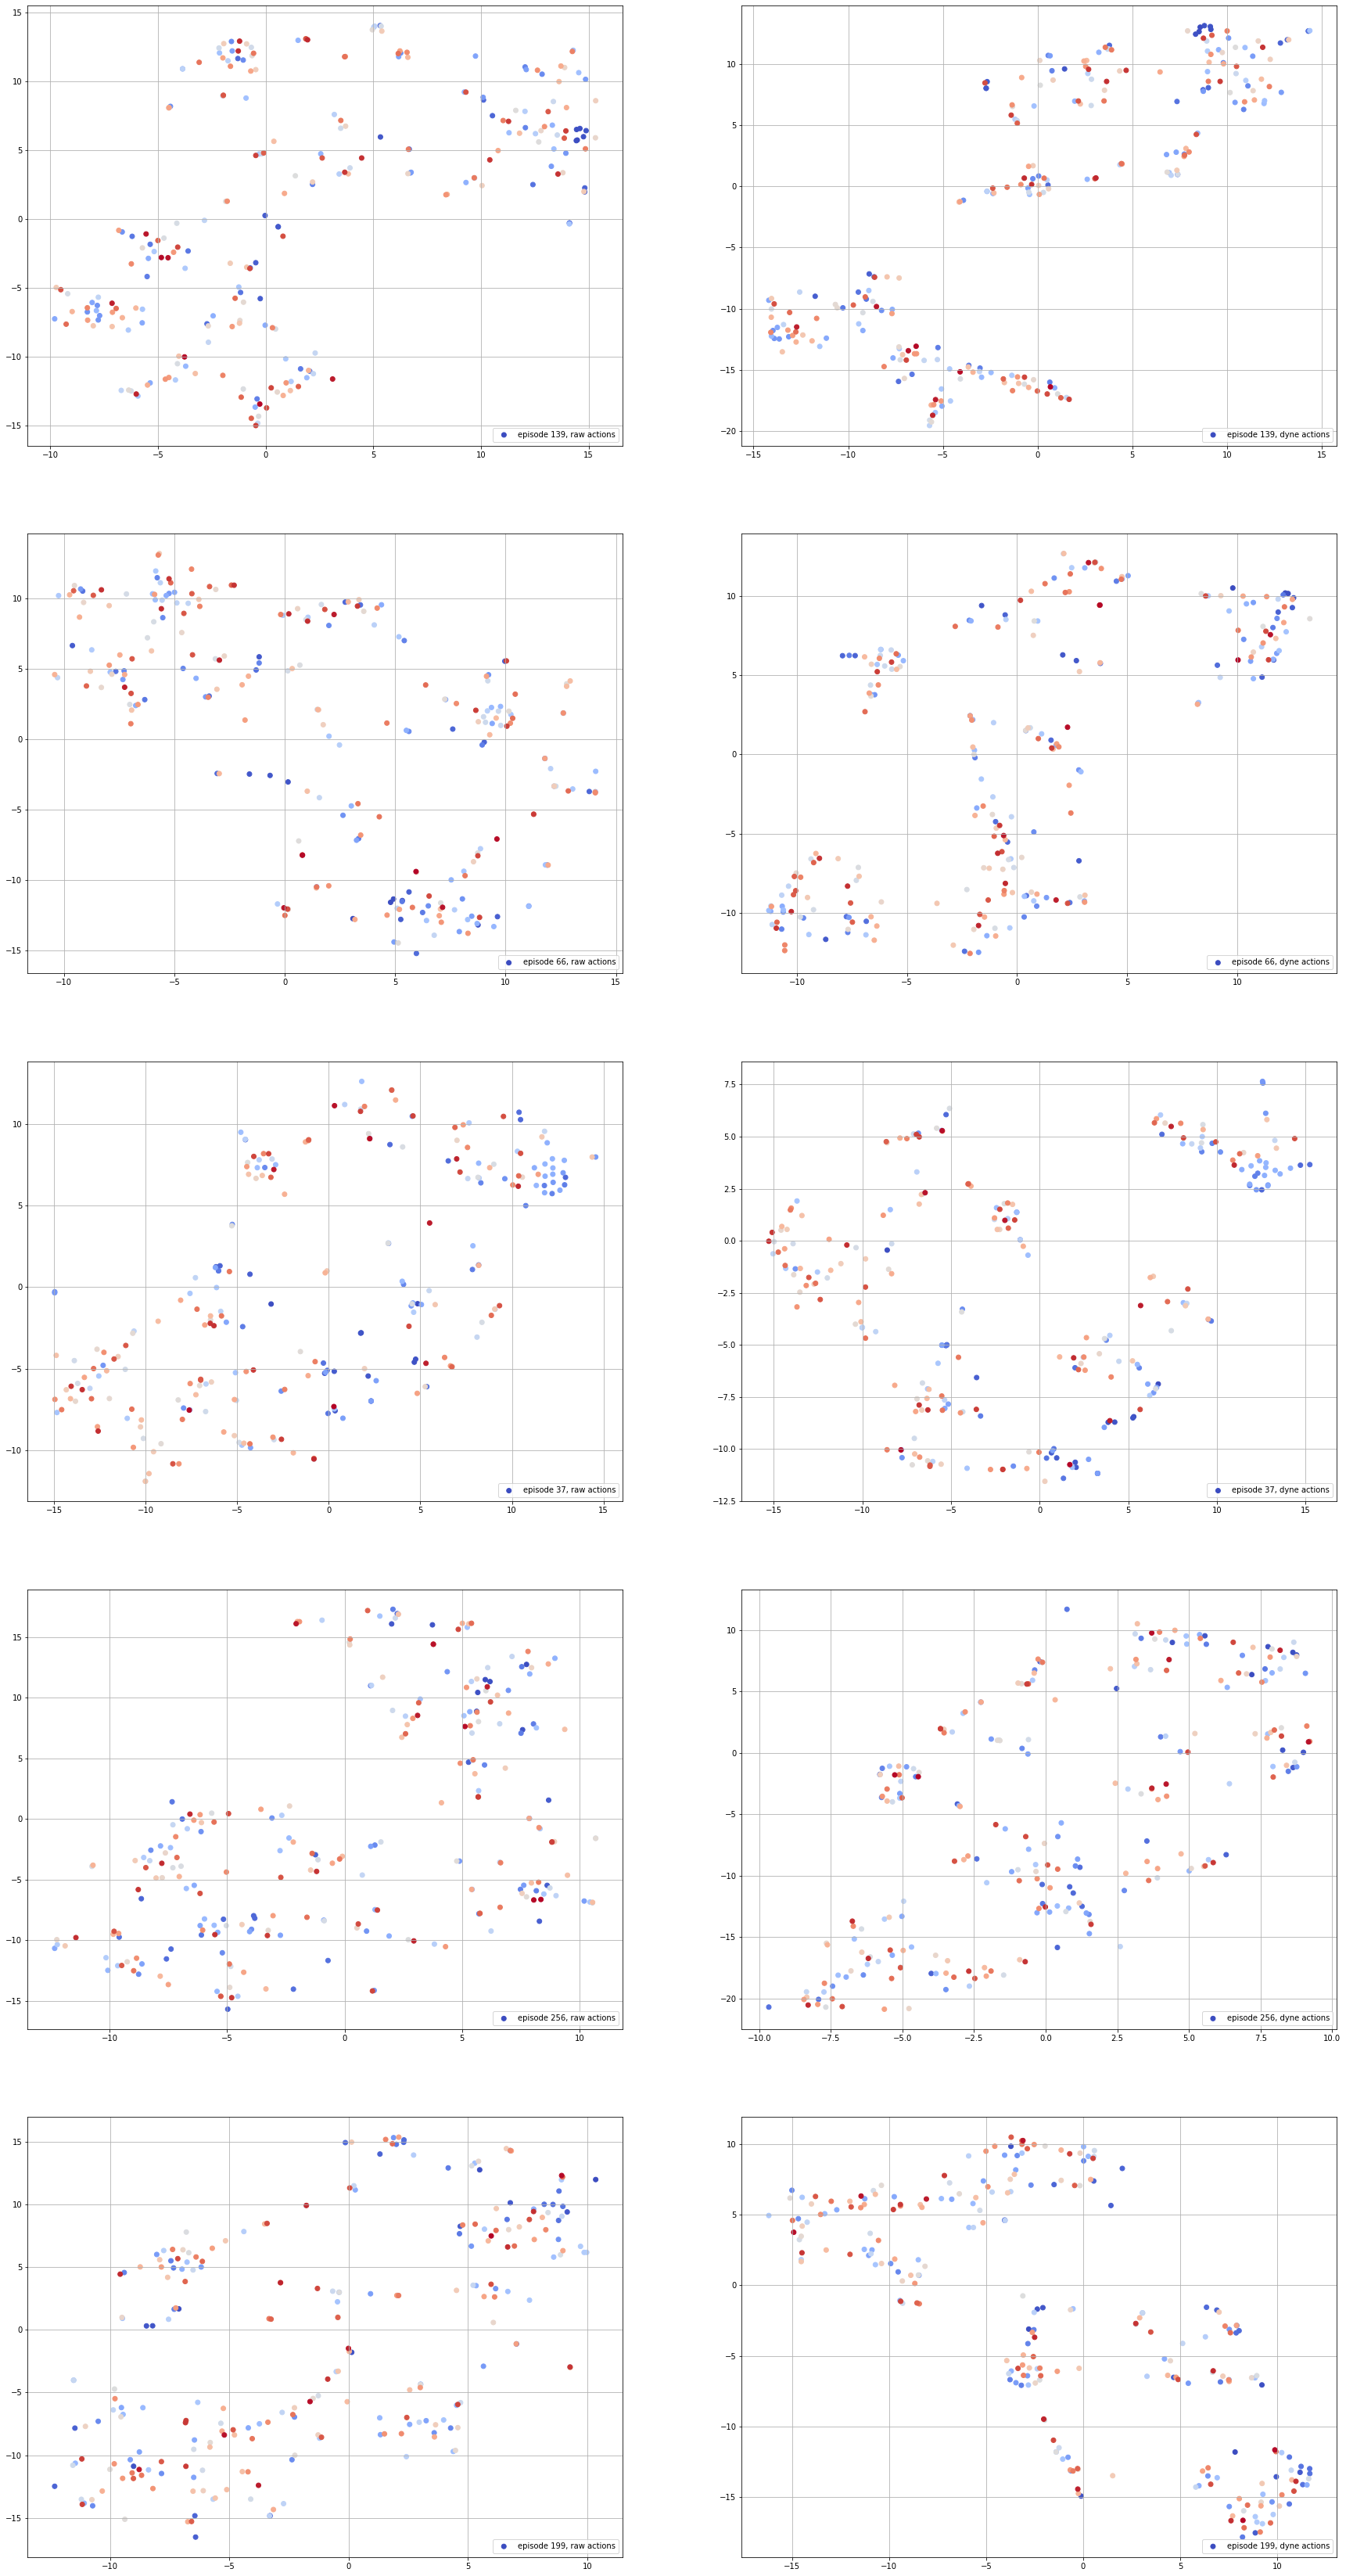

In [136]:
compare_embeddings_vis_2d('raw vs dyne actions', data, 5, a_text=0, log=True)

In [7]:
def vis_embeddings(label, embeddings, words=[], a_points=1, a_text=0.6, ax=None):
    colors = cm.coolwarm(np.linspace(0, 1, len(embeddings)))
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    ax.scatter(x, y, c=colors, alpha=a_points, label=label)
    for i, word in enumerate(words):
        ax.annotate(word, alpha=a_text, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom', size=10)
    ax.legend(loc=4)
    ax.grid(True)
    
def compare_embeddings_vis_2d(traj_len, label, data, n_samples, a_points=1, a_text=0.6, log=True, images_path=None):
    sample_idx = random.sample(range(len(data)), n_samples)
    fig, axes = plt.subplots(n_samples, 2, figsize=(30, 60))

    for idx, s in enumerate(sample_idx):

        raw_obs, raw_action, raw_reward = data[s]
        raw_action = torch.repeat_interleave(raw_action[1:], 2, dim=0)
        action_dim = raw_action.size(1)
        initial_episode_size = raw_action.size(0)
        actual_episode_size = initial_episode_size - (initial_episode_size % traj_len)
        raw_action = raw_action[:actual_episode_size]
        raw_embeddings = raw_action.reshape([actual_episode_size // traj_len,
                                             traj_len * action_dim])

        mu, logvar = data.transform_episode(s)

        numbers_ak = []
        embeddings_ak = []
        for k, vector in enumerate(raw_embeddings):
            embeddings_ak.append(vector.numpy())
            numbers_ak.append(k)

        tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

        vis_embeddings("episode {}, raw actions".format(s), embeddings_ak_2d,
                       numbers_ak, a_points=a_points, a_text=a_text, ax=axes[idx][0])

        dyne_numbers_ak = []
        dyne_emb_ak = []

        for k, vector in enumerate(mu):
            dyne_emb_ak.append(vector.numpy())
            dyne_numbers_ak.append(k)

        tsne_dyne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
        embeddings_dyne_ak_2d = tsne_dyne_ak_2d.fit_transform(dyne_emb_ak)

        vis_embeddings("episode {}, dyne actions".format(s), embeddings_dyne_ak_2d,
                       dyne_numbers_ak, a_points=a_points, a_text=a_text, ax=axes[idx][1])

    fig.savefig(images_path / 'comparison.png', format='png', dpi=150, bbox_inches='tight')
    if log:
        wandb.log({label: wandb.Image(fig)})
    else:
        plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

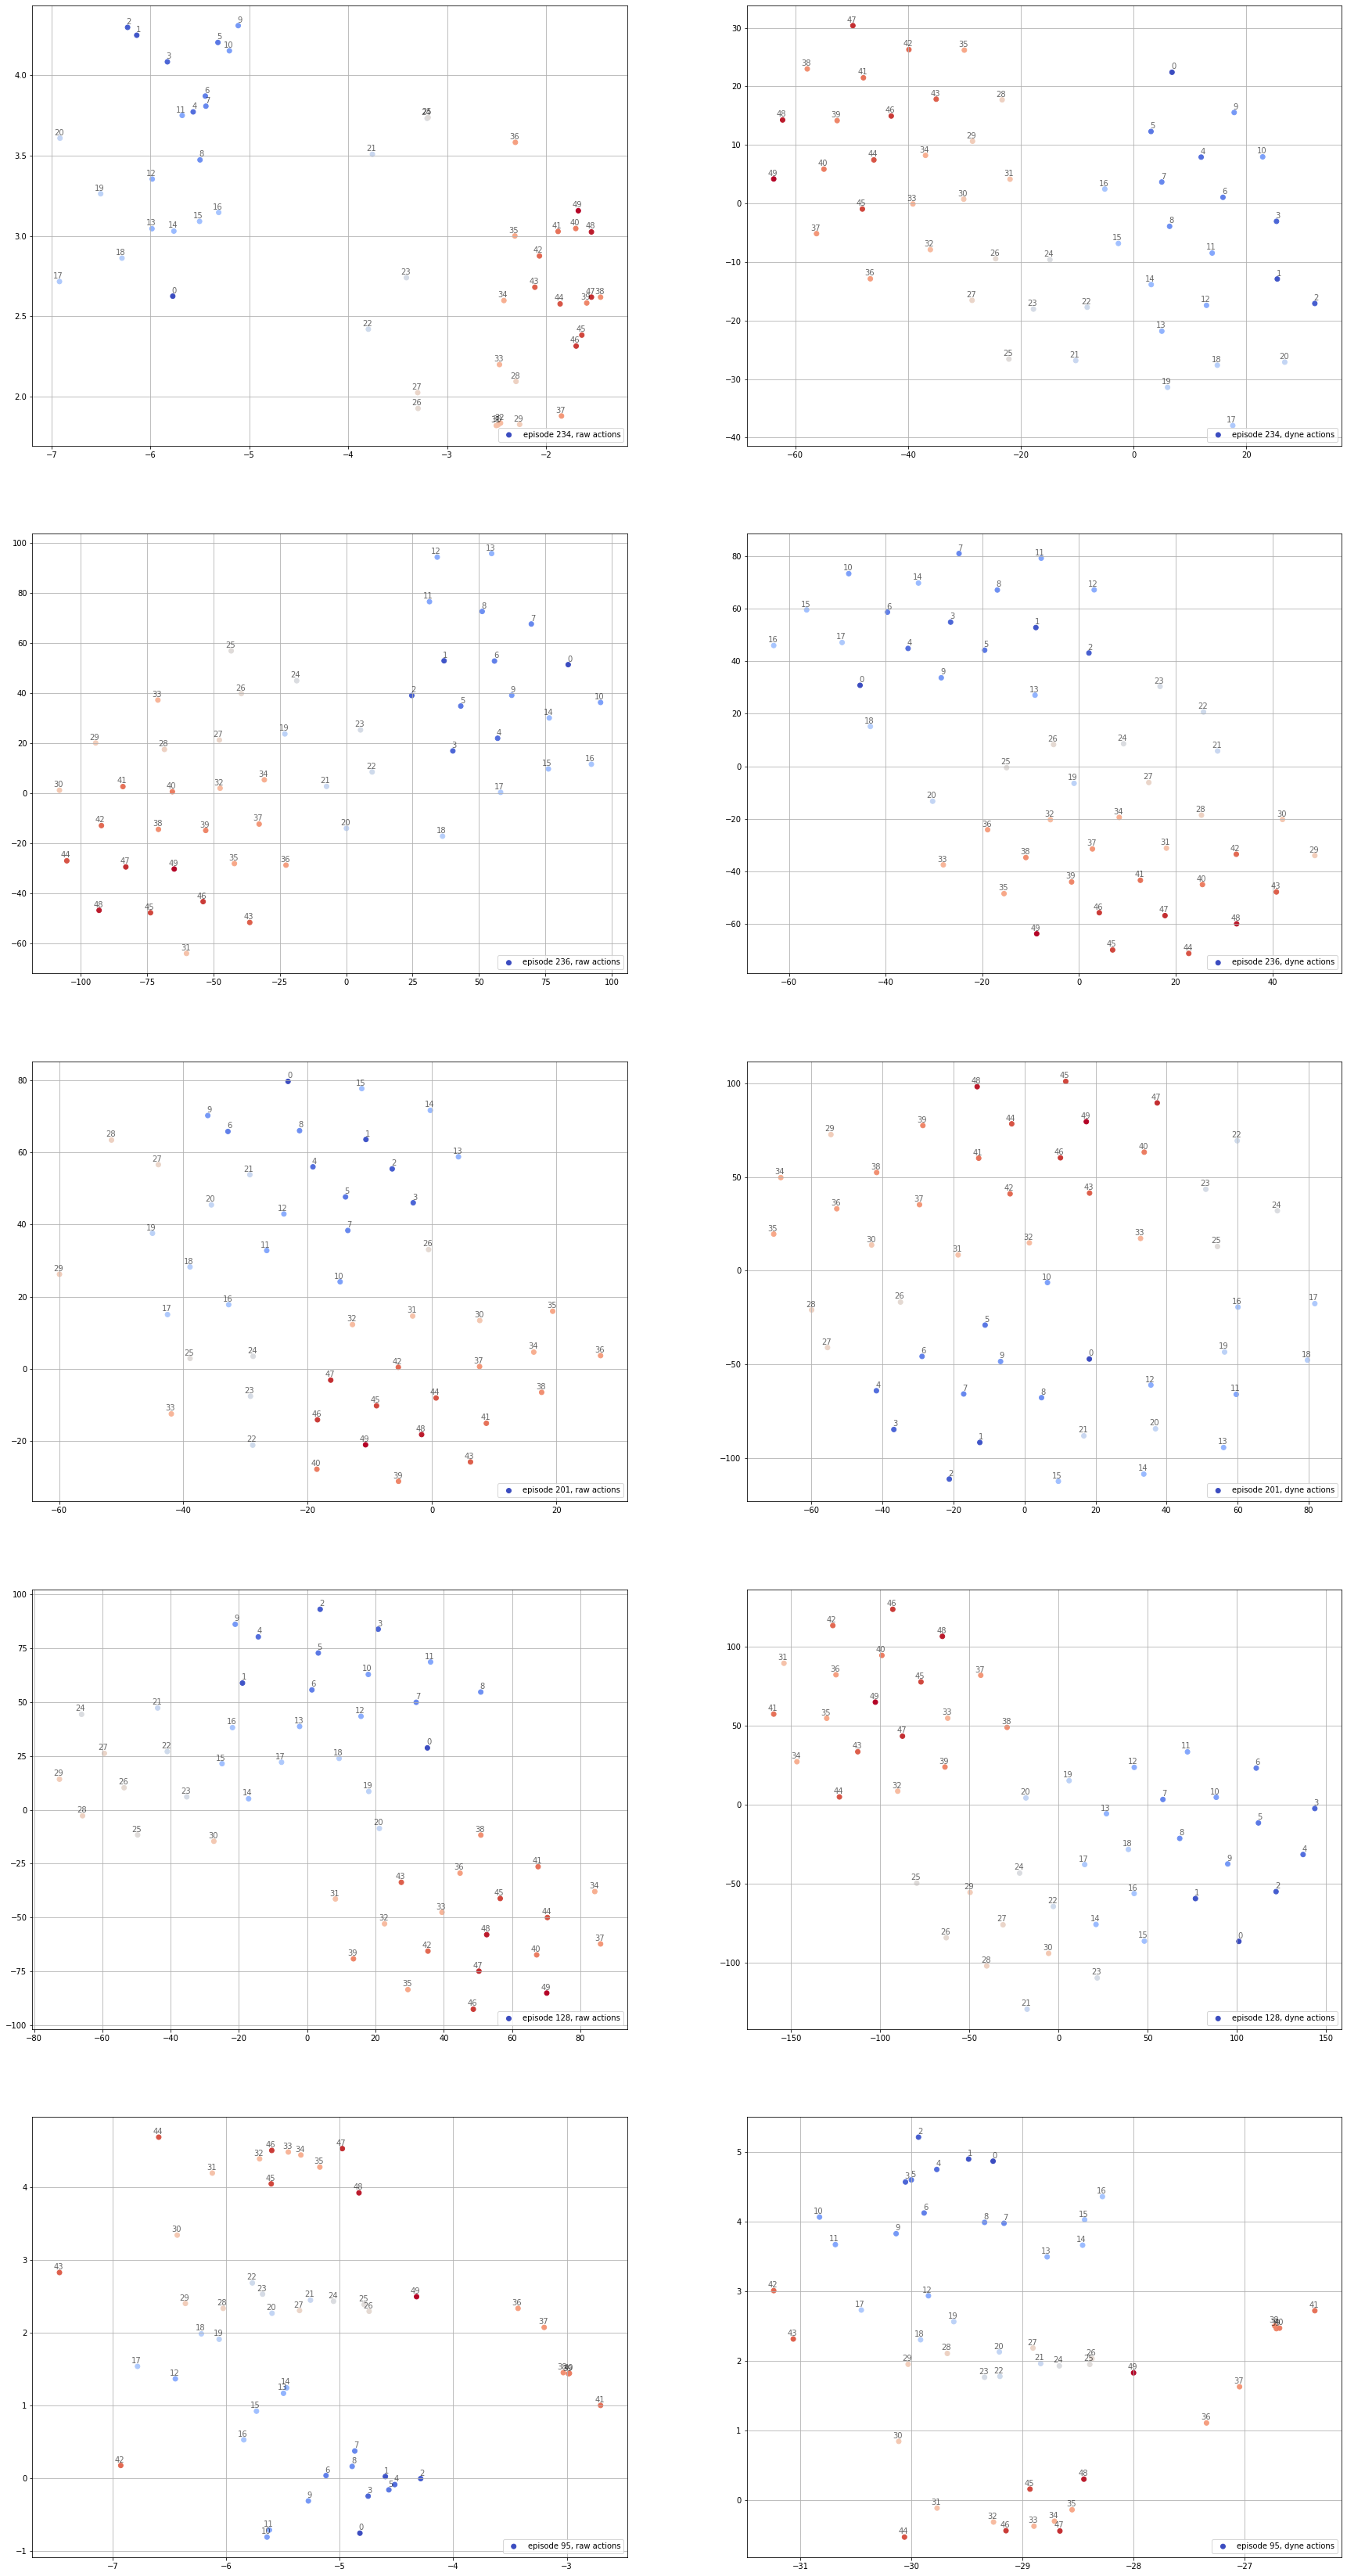

In [8]:
import pathlib

compare_embeddings_vis_2d(4, 'raw vs dyne', data, 5, log=False, images_path = pathlib.Path('./try.png'))